In [1]:
#Imports:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import random

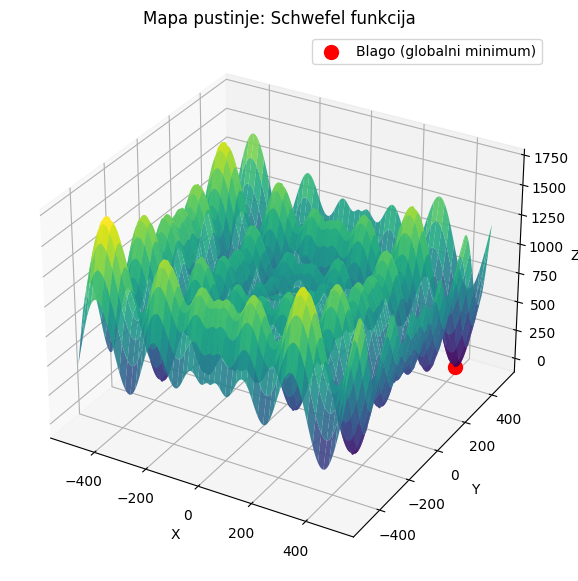

In [7]:
def schwefel_2d(x, y):
    """
    Schwefel funkcija 2D:
    f(x, y) = 418.9829*2 - x*sin(sqrt(|x|)) - y*sin(sqrt(|y|))
    Globalni minimum: (420.9687, 420.9687), vrednost = 0
    """
    return 418.9829*2 - x*np.sin(np.sqrt(np.abs(x))) - y*np.sin(np.sqrt(np.abs(y)))

# Kreiranje mreže
x = np.linspace(-500, 500, 400)
y = np.linspace(-500, 500, 400)
X, Y = np.meshgrid(x, y)
Z = schwefel_2d(X, Y)

# 3D prikaz funkcije
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)

# Obeležavanje globalnog minimuma
ax.scatter(420.9687, 420.9687, 0, color='red', s=100, label='Blago (globalni minimum)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Mapa pustinje: Schwefel funkcija')
ax.legend()
plt.show()
